In [1]:
#Import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px 
import math 
import statistics as st
from collections import Counter
import scipy.stats as sp
import seaborn as sns 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.Preprocesado de los datos
---

In [2]:
#Cargo el dataset
url = 'https://raw.githubusercontent.com/juliajjm/modulo2_practica4/main/act4_kc_house_data.csv'
df_precios = pd.read_csv(url, sep = ',', decimal ='.')

Convertir las áreas a metros cuadrados

In [3]:
#df_precios.head()
#constante para dividir en metros cuadrados 
sqft_m2 = 10.764 

df_precios[["sqft_living" , "sqft_lot" , "sqft_above" , "sqft_basement" , "sqft_living15" , "sqft_lot15" ]] /= sqft_m2
df_precios.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,109.624675,524.897808,1.0,0,0,...,7,109.624675,0.000000,1955,0,98178,47.5112,-122.257,124.489038,524.897808
1,6414100192,20141209T000000,538000.0,3,2.25,238.758826,672.798216,2.0,0,0,...,7,201.597919,37.160907,1951,1991,98125,47.7210,-122.319,157.004831,709.680416
2,5631500400,20150225T000000,180000.0,2,1.00,71.534745,929.022668,1.0,0,0,...,6,71.534745,0.000000,1933,0,98028,47.7379,-122.233,252.694166,748.978075
3,2487200875,20141209T000000,604000.0,4,3.00,182.088443,464.511334,1.0,0,0,...,7,97.547380,84.541063,1965,0,98136,47.5208,-122.393,126.347083,464.511334
4,1954400510,20150218T000000,510000.0,3,2.00,156.075808,750.650316,1.0,0,0,...,8,156.075808,0.000000,1987,0,98074,47.6168,-122.045,167.224080,697.045708


Convertir la fecha de venta en string “YYYYMMDD”

In [ ]:
df_precios["date"] = pd.to_datetime(df_precios["date"])
df_precios["date"] = df_precios["date"].dt.strftime("%Y%m%d")
#df_precios.head()
df_precios.info()


# 2.Estimación de precios
---


2.1 Árboles de decisión
---


In [5]:
#Utilizar el algoritmo de Árboles de Decisión. 
#Regresión: cuando la variable objetivo es continua (precios de productos, etc.)

from sklearn.tree import DecisionTreeRegressor


In [6]:
#division train & test 
X = df_precios.drop("price" , axis = 1)
y = df_precios.iloc[:,2]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    random_state=42, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(15129, 20) (15129,)
(6484, 20) (6484,)


In [8]:
#Bucle para la selección de "max_depth"
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [9]:
md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)
  tree_model.fit(X_train, y_train)

  pred_train = tree_model.predict(X_train)
  pred_test = tree_model.predict(X_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train, y_train))
  score_test_list.append(100.0*tree_model.score(X_test, y_test))
  mse_train_list.append(mean_squared_error(y_train, pred_train))
  mse_test_list.append(mean_squared_error(y_test, pred_test))

df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

In [36]:
df.set_index("max_depth", inplace=True)

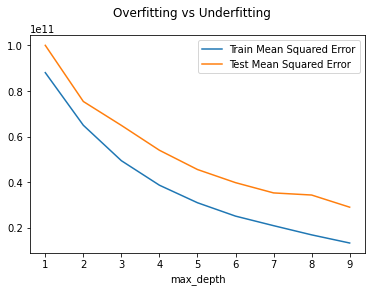

In [37]:
df["mse_train"].plot(label="Train Mean Squared Error") 
df["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

Observo que el error medio cuadrático de Train y Test decrece. Los valores se sobreajustan, ya que este error medio cuadrático baja rápidamente y además disminuye mucho.


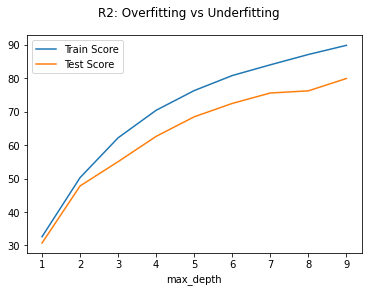

In [38]:
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

El R2 de Train y Test sube mucho, en este caso sube más en los valores de Train que en los de Test.


Entrenamiento y evaluación del modelo

In [39]:
from sklearn.tree import plot_tree
tree_model = DecisionTreeRegressor(random_state=0, max_depth=3)
tree_model.fit(X_train, y_train)
pred_train = tree_model.predict(X_train)
print (r2_score(y_train, pred_train))

0.6215631450853705


Cálculo de la Importancia de las Variables

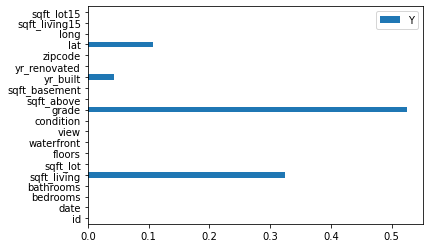

In [40]:
df_imp = pd.DataFrame(tree_model.feature_importances_.reshape(1,-1), columns=X.columns, index=["Y"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Observo que las variables que tienen más importancia son grade, sqrt_living, lat y yr_build.

Generación del Grafo para su análisis

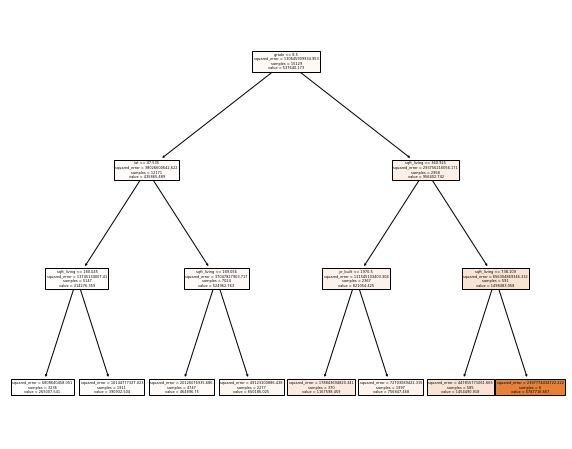

In [41]:
plt.figure(figsize=(10,8))
plot_tree(tree_model, filled=True, max_depth=3, feature_names=X.columns, class_names=["Y"])
plt.show()

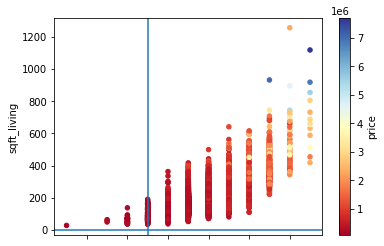

In [42]:
df_precios.plot.scatter(x="grade", y="sqft_living", c="price", cmap=plt.cm.RdYlBu)
plt.axvline(5.0)
plt.axhline(0.5)

Observo que la división de Y para los valores bajos y altos no es muy buena ya que los valores estan bastante dispersos y no parecen seguir un patrón. Esto también puede relacionarse con los problemas a la hora de tener un R2 suficiente.

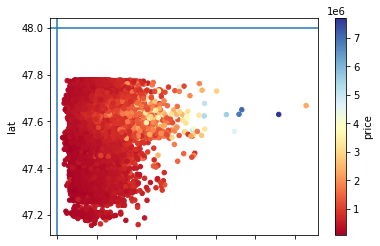

In [43]:
df_precios.plot.scatter(x="sqft_living", y="lat", c="price", cmap=plt.cm.RdYlBu)
plt.axvline(1)
plt.axhline(48)

En este segundo gráfico las valores de la Y parecen estar mejor dividios, siguen un patrón ya que a la izquierda nos encontramos los valores bajos de la Y agrupados.

2.2 Utilizar el algoritmo de Random Forest. 
---


In [44]:
from sklearn.model_selection import train_test_split


In [45]:
df_precios_new = df_precios.drop("date" , axis = 1)

df_precios_train , df_precios_test = train_test_split(df_precios_new , test_size = 0.2 , train_size = 0.8)
print(df_precios_train.shape)
print(df_precios_test.shape)

x_train = df_precios_train.drop("price" , axis = 1).values
y_train = df_precios_train.iloc[:,1].values

x_test = df_precios_test.drop("price" , axis = 1).values
y_test = df_precios_test.iloc[:,1].values




(17290, 20)
(4323, 20)


In [46]:
print (x_train.shape)
print (x_test.shape)

(17290, 19)
(4323, 19)


In [47]:
y_test

array([212500., 215000., 408000., ..., 324950., 520000., 490000.])

# Modelo Random Forest
---

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=5, random_state=0, n_jobs=5)
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=5, random_state=0)

In [49]:
pred_train = rf_model.predict(x_train)
pred_test = rf_model.predict(x_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model.score(x_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model.score(x_test, y_test)))

Precisión sobre los datos de entrenamiento: 6.93
Precisión sobre los datos de test: 1.60


Evaluación del modelo
---

In [50]:
from sklearn import metrics

In [ ]:
print(f"Classification report for classifier {rf_model}:\n"
      f"{metrics.classification_report(y_test, pred_test)}\n")

In [ ]:
print(f"Confusion matrix:\n")
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(rf_model, x_test, y_test, cmap=plt.cm.viridis, ax=ax)
plt.show()

Confusion matrix:



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Optimización del modelo
---

In [2]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1,30,4)):
  rf_model = RandomForestClassifier(random_state=0, max_depth=maxdepth, n_jobs=5)
  rf_model.fit(x_train, y_train)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(x_train, y_train))
  score_test_list.append(100.0*rf_model.score(x_test, y_test))

NameError: ignored

In [ ]:
df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

In [ ]:
rf_model_15 = RandomForestClassifier(max_depth=15, random_state=0, n_jobs=5)
rf_model_15.fit(x_train,y_train)

In [ ]:
pred_train = rf_model_15.predict(x_train)
pred_test = rf_model_15.predict(x_test)
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model_15.score(x_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model_15.score(x_test, y_test)))

In [ ]:
print(f"Confusion matrix:\n")
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(rf_model_15, x_test, y_test, cmap=plt.cm.viridis, ax=ax)
plt.show()

2.3 Utilizar el algoritmo de Grandient Boosting.
---

El concepto en el que se basa Gradient Boosting es el de tratar de lanzar árboles de decisión, uno detrás de otro, de tal manera que cada uno modelice los errores del anterior. Se puede ver como un optimizador de la función de coste.

In [1]:
df_precios_train.set_index("price").plot(subplots=True, figsize=(8,8));

NameError: ignored

In [ ]:
df_precios_test.set_index("price").plot(subplots=True, figsize=(8,8));

# 3.Evaluación de los modelos: 
---


Comparar los valores de R2 de ambos modelos.
 
Comentar los resultados. 


**Modelo 1: árbol de decisión (regresión)**
---
Para este modelo elijo el árbol de decisión, regresión (algoritmo supervisado), ya que la variable objetivo es continua (precios de productos, etc.). 
En el modelo 1 el error medio cuadrático de Train y Test decrece, lo cual es buena señal, aunque es importante evitar el sobreajuste. 
En relación al R2, este sube considerablemente tanto para Train como para Test. Obtengo un R2 del 62% en la evaluación del modelo.


**Modelo 2**
---





**Modelo 3**
---
